In [2]:
def fn_variance(data, ddof=0):   
    n = len(data)   
    mean = sum(data) / n
    return sum((x - mean) ** 2 for x in data) / (n - ddof)    
# Note this is equivalent to np.var(Yt,ddof)

In [3]:
def fn_generate_cov(dim):
    acc  = []                         
    for i in range(dim): 
        row = np.ones((1,dim)) * corr  
        row[0][i] = 1                  
        acc.append(row)                
    return np.concatenate(acc,axis=0) 

In [4]:
def fn_generate_multnorm(nobs,corr,nvar):

    mu = np.zeros(nvar)   
    std = (np.abs(np.random.normal(loc = 1, scale = .5,size = (nvar,1))))**(1/2)
    acc = []
    for i in range(nvar):
        acc.append(np.reshape(np.random.normal(mu[i],std[i],nobs),(nobs,-1))) 
    
    normvars = np.concatenate(acc,axis=1)

    cov = fn_generate_cov(nvar)
    C = np.linalg.cholesky(cov)

    Y = np.transpose(np.dot(C,np.transpose(normvars)))

#     return (Y,np.round(np.corrcoef(Y,rowvar=False),2))
    return Y

In [5]:
def fn_randomize_treatment(N,p=0.5): 
    '''
    define T(generate treatment)
    '''
    treated = random.sample(range(N), round(N*p))
    return np.array([(1 if i in treated else 0) for i in range(N)]).reshape([N,1])

In [6]:
import pandas as pd
import numpy as np
import random
import statsmodels.api as sm
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Lasso
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from tqdm import tqdm
import graphviz as gr
random.seed(10)

In [7]:
def fn_generate_data(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)   
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment 
    C = allX[:,1].reshape([N,1]) # confounder  
    X = allX[:,2:] # observed covariates  
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])   
    beta0 = np.random.normal(5,5,[p,1]) 
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err #outcome equation
    if flagX==False:
        return (Yab,T)
    else:
        return (Yab,T,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

In [8]:
def fn_tauhat_means(Yt,Yc): #Yt:treatment group    Yc:Control Group
    nt = len(Yt)
    nc = len(Yc)
    tauhat = np.mean(Yt)-np.mean(Yc)  #Estimated treatment effect, should be closed to real tau(=2) if N is large
    se_tauhat = (np.var(Yt,ddof=1)/nt+np.var(Yc,ddof=1)/nc)**(1/2)     #se:standard errors
    return (tauhat,se_tauhat)

In [9]:
def fn_bias_rmse_size(theta0,thetahat,se_thetahat,cval = 1.96):
    """
    theta0 - true parameter value？？？是哪个参数？？？？？
    thetatahat - estimated parameter value
    se_thetahat - estiamted se of thetahat
    """
    b = thetahat - theta0
    bias = np.mean(b)  
    rmse = np.sqrt(np.mean(b**2))  
    tval = b/se_thetahat # paramhat/se_paramhat H0: theta = 0  #tval: t-statistics
    size = np.mean(1*(np.abs(tval)>cval))
    # note size calculated at true parameter value
    return (bias,rmse,size)

In [10]:
def fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX=False):   
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            #"No X's included"
            Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf,flagX)
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX) 
            Xobs = X[:,:p0]   
            covars = np.concatenate([T,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,X = fn_generate_data(tau,N,p,p0,corr,conf,flagX)  
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):]  
            covars = np.concatenate([T,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

In [11]:
def fn_plot_with_ci(n_values,tauhats,tau,lb,ub,caption):
    fig = plt.figure(figsize = (10,6))
    #plots x against y
    #the label is what comes out in the legend
    plt.plot(n_values,tauhats,label = '$\hat{\\tau}$')
    plt.xlabel('N')
    plt.ylabel('$\hat{\\tau}$')
    #axhline is a horizontal line at the true value of tau
    plt.axhline(y=tau, color='r', linestyle='-',linewidth=1,
                label='True $\\tau$={}'.format(tau))
    plt.title('{}'.format(caption))
    #fill confidence interval 
    #alpha is the capacity of the fill
    plt.fill_between(n_values, lb, ub,
        alpha=0.5, edgecolor='#FF9848', facecolor='#FF9848',label = '95% CI')
    plt.legend()

# 1.Simulate a DGP where the outcome of interest depends on a randomly assigned treatment and some observed covariates

## a. You do not control for any covariates

### Simulate a DGP

In [12]:
tau = 2   ##treatment effect parameter
corr = .5 #correlation between covariates
conf=False 
flagX=False
p = 8 # number of covariates generated
p0 = 4 # number of covariates used in the DGP
Nrange = range(10,1000,2) 
(nvalues,tauhats,sehats,lb,ub) = fn_run_experiments(tau,Nrange,p,p0,corr,conf) 

100%|██████████| 495/495 [00:01<00:00, 269.81it/s]


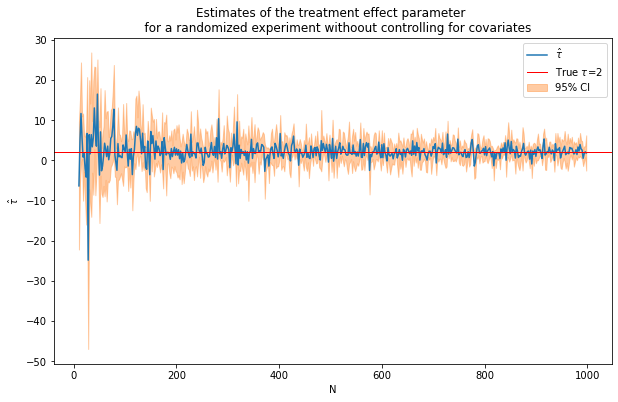

In [13]:
caption = """Estimates of the treatment effect parameter 
    for a randomized experiment withoout controlling for covariates """
fn_plot_with_ci(nvalues,tauhats,tau,lb,ub,caption)

### Illustrate your DGP with a DAG

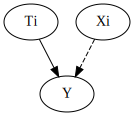

In [14]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("Xi","Y",style="dashed")
g

### Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is.

In [15]:
estDict = {}
R = 2000
for N in [100,1000]: #we have different sample sizes. For each sample size, we are going to run 2000 replications of generating the data.
    tauhats = []
    sehats = []
    for r in tqdm(range(R)): 
        Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]  
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]
    estDict[N] = {
        'tauhat':np.array(tauhats).reshape([len(tauhats),1]),
        'sehat':np.array(sehats).reshape([len(sehats),1])
    }

100%|██████████| 2000/2000 [00:17<00:00, 111.77it/s]


In [16]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat'],
                                         results['sehat'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.07918438134007559, RMSE=3.618950588579179, size=0.047
N=1000: bias=-0.0015522605102671694, RMSE=1.2148925523820513, size=0.046


### Give an example of a real-life situation that might be consistent with the DGP.

There are many factors affecting wages, such as education level, gender, work experience and whether to participate in a job training program(which is assigned to individuals). However, if you do not control for any covariates,the average treatment effect would be biased.

## b. You control for all the covariates that affect the outcome

### Simulate a DGP

In [17]:
tau = 2
corr = .5
conf=False
p = 8  #number of covariates generated
p0 = 4 # number of covariates used in the DGP
flagX=1
Nrange = range(10,1000,2) # loop over N values
(nvalues_x,tauhats_x,sehats_x,lb_x,ub_x) = fn_run_experiments(tau,Nrange,p,p0,corr,conf) 

100%|██████████| 495/495 [00:01<00:00, 260.85it/s]


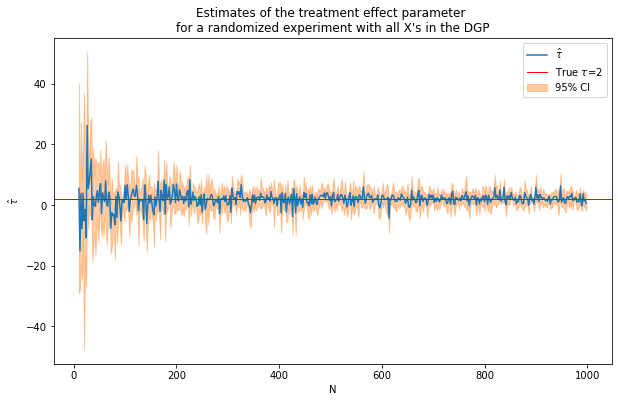

In [19]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with all X's in the DGP"""  
fn_plot_with_ci(nvalues_x,tauhats_x,tau,lb_x,ub_x,caption)

### Illustrate your DGP with a DAG

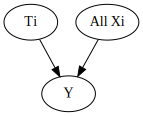

In [20]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("All Xi","Y")
g

### Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is

In [21]:
estDict = {}
R = 2000
for N in [100,1000]: #we have different sample sizes. For each sample size, we are going to run 2000 replications of generating the data.
    tauhats_x = []
    sehats_x = []
    for r in tqdm(range(R)): 
        Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]  
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat_x,se_tauhat_x = fn_tauhat_means(Yt,Yc)
        tauhats_x = tauhats_x + [tauhat_x]
        sehats_x = sehats_x + [se_tauhat_x]
    estDict[N] = {
        'tauhat_x':np.array(tauhats_x).reshape([len(tauhats_x),1]),
        'sehat_x':np.array(sehats_x).reshape([len(sehats_x),1])
    }

100%|██████████| 2000/2000 [00:17<00:00, 112.32it/s]


In [22]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat_x'],
                                         results['sehat_x'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.04496885413435758, RMSE=3.6869746116279085, size=0.046
N=1000: bias=0.014477931574888945, RMSE=1.2333317970801798, size=0.0555


### Give an example of a real-life situation that might be consistent with the DGP.

In the above case, if we control for all the covariates that affect the outcome(education level, gender, work experience and whether to participate in a job training program), we can conclude that the predicted value is more accurate and less variant.

# 2. Simulate a DGP with a confounder (common cause)

## a. You fail to control for the confounder

### Simulate a DGP

In [23]:
tau = 2
corr = .5
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1  #use the right covariates in regression
(nvalues2,tauhats2,sehats2,lb2,ub2) = fn_run_experiments(tau,Nrange,p,p0,corr,conf,flagX)

100%|██████████| 450/450 [00:08<00:00, 55.60it/s]


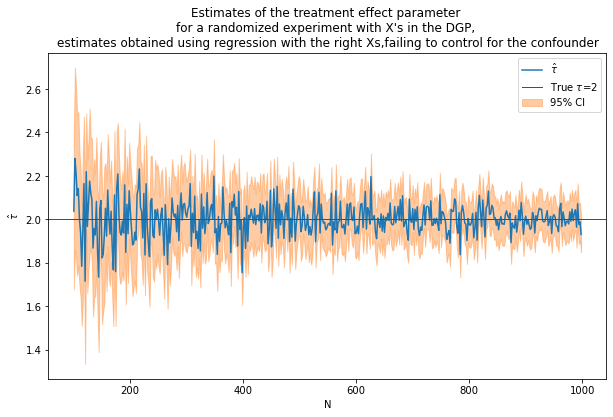

In [24]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP, 
estimates obtained using regression with the right Xs,failing to control for the confounder"""
fn_plot_with_ci(nvalues2,tauhats2,tau,lb2,ub2,caption)

### Illustrate your DGP with a DAG

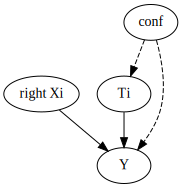

In [25]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("right Xi","Y")
g.edge("conf","Y", style="dashed")
g.edge("conf","Ti",style="dashed")
g

### Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is

In [26]:
estDict = {}
R = 2000
for N in [100,1000]: #we have different sample sizes. For each sample size, we are going to run 2000 replications of generating the data.
    tauhats2 = []
    sehats2 = []
    for r in tqdm(range(R)): 
        Yexp,T = fn_generate_data(tau,N,p,p0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:]  
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat2,se_tauhat2 = fn_tauhat_means(Yt,Yc)
        tauhats2 = tauhats2 + [tauhat2]
        sehats2 = sehats2 + [se_tauhat2]
    estDict[N] = {
        'tauhat2':np.array(tauhats2).reshape([len(tauhats2),1]),
        'sehat2':np.array(sehats2).reshape([len(sehats2),1])
    }

100%|██████████| 2000/2000 [00:39<00:00, 51.13it/s]


In [27]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat2'],
                                         results['sehat2'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.5418707862703749, RMSE=36.395220858149386, size=0.0535
N=1000: bias=0.11299828020990663, RMSE=11.31569130273735, size=0.045


### Give an example of a real-life situation that might be consistent with the DGP.

For example, let's say that the treatment is education and the outcome is income. It is hard to know the causal effect of education on the wage because both share a common cause: intelligence. If we fail to control for the confounder, others may argue that more educated people earn more money simply because they are more intelligent, not because they have more education.

## b. You do control for the confounder

### Simulate a DGP

In [28]:
def fn_generate_data1(tau,N,p,p0,corr,conf = True,flagX = False):
    """
    p0(int): number of covariates with nonzero coefficients
    """
    nvar = p+2 # 1 confounder and variable for randomizing treatment
    corr = 0.5 # correlation for multivariate normal

    if conf==False:
        conf_mult = 0 # remove confounder from outcome
        
    allX = fn_generate_multnorm(N,corr,nvar)  
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment 
    C = allX[:,1].reshape([N,1]) # confounder  
    X = allX[:,2:] # observed covariates  
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])   
    beta0 = np.random.normal(5,5,[p,1])
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+conf_mult*0.6*C+err #outcome equation
    if flagX==False:
        return (Yab,T,C)
    else:
        return (Yab,T,C,X)
    
    # regression discontinuity
#     W = W0 + 0.5*C+3*X[:,80].reshape([N,1])-6*X[:,81].reshape([N,1])
#     treated = 1*(W>0)
#     Yrdd = 1.2* treated - 4*W + X@beta0 +0.6*C+err

In [29]:
def fn_run_experiments1(tau,Nrange,p,p0,corr,conf,flagX=False):   
    n_values = []
    tauhats = []
    sehats = []
    lb = []
    ub = []
    for N in tqdm(Nrange):
        n_values = n_values + [N]
        if flagX==False:
            #"No X's included"
            Yexp,T,C = fn_generate_data1(tau,N,p,p0,corr,conf,flagX)  
            Yt = Yexp[np.where(T==1)[0],:]
            Yc = Yexp[np.where(T==0)[0],:]
            tauhat,se_tauhat = fn_tauhat_means(Yt,Yc)            
        elif flagX==1:
            # use the right covariates in regression
            Yexp,T,C,X = fn_generate_data1(tau,N,p,p0,corr,conf,flagX) 
            Xobs = X[:,:p0]   
            covars = np.concatenate([T,C,Xobs],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0]
            se_tauhat = res.HC1_se[0]
        elif flagX==2:
            # use some of the right covariates and some "wrong" ones
            Yexp,T,C,X = fn_generate_data1(tau,N,p,p0,corr,conf,flagX)  
            Xobs1 = X[:,:np.int(p0/2)]
            Xobs2 = X[:,-np.int(p0/2):] 
            covars = np.concatenate([T,C,Xobs1,Xobs2],axis = 1)
            mod = sm.OLS(Yexp,covars)
            res = mod.fit()
            tauhat = res.params[0] 
            se_tauhat = res.HC1_se[0]
            
        tauhats = tauhats + [tauhat]
        sehats = sehats + [se_tauhat]    
        lb = lb + [tauhat-1.96*se_tauhat]
        ub = ub + [tauhat+1.96*se_tauhat]
        
    return (n_values,tauhats,sehats,lb,ub)

In [30]:
tau = 2
corr = .5
p = 100
p0 = 50 # number of covariates used in the DGP
Nrange = range(100,1000,2) # loop over N values
# we need to start with more observations than p
flagX = 1  #use the right covariates in regression
(nvalues3,tauhats3,sehats3,lb3,ub3) = fn_run_experiments1(tau,Nrange,p,p0,corr,conf,flagX)

100%|██████████| 450/450 [00:08<00:00, 56.17it/s]


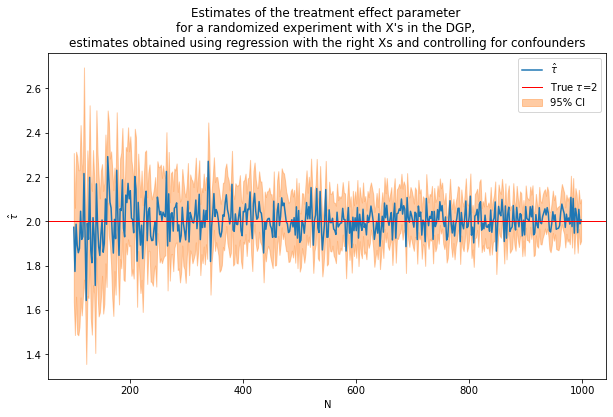

In [31]:
caption = """Estimates of the treatment effect parameter 
for a randomized experiment with X's in the DGP, 
estimates obtained using regression with the right Xs and controlling for confounders"""
fn_plot_with_ci(nvalues3,tauhats3,tau,lb3,ub3,caption)

### Illustrate your DGP with a DAG

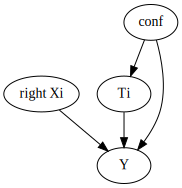

In [32]:
g = gr.Digraph()
g.edge("Ti","Y")
g.edge("right Xi","Y")
g.edge("conf","Y")
g.edge("conf","Ti")
g

### Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is

In [33]:
estDict = {}
R = 2000
for N in [100,1000]: #we have different sample sizes. For each sample size, we are going to run 2000 replications of generating the data.
    tauhats3 = []
    sehats3 = []
    for r in tqdm(range(R)): 
        Yexp,T,C = fn_generate_data1(tau,N,p,p0,corr,conf)
        Yt = Yexp[np.where(T==1)[0],:] 
        Yc = Yexp[np.where(T==0)[0],:]
        tauhat3,se_tauhat3 = fn_tauhat_means(Yt,Yc)
        tauhats3 = tauhats3 + [tauhat3]
        sehats3 = sehats3 + [se_tauhat3]
    estDict[N] = {
        'tauhat3':np.array(tauhats3).reshape([len(tauhats3),1]),
        'sehat3':np.array(sehats3).reshape([len(sehats3),1])
    }

100%|██████████| 2000/2000 [00:38<00:00, 51.66it/s]


In [34]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat3'],
                                         results['sehat3'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.023232631080012483, RMSE=36.19708566108199, size=0.0515
N=1000: bias=0.05069457560882769, RMSE=11.494785162995575, size=0.054


### Give an example of a real-life situation that might be consistent with the DGP.

let's say that the treatment is education and the outcome is income. It is hard to know the causal effect of education on the wage because both share a common cause: intelligence. In our example, if we control for intelligence, that is, we compare people with the same level of intelligence but different levels of education, the difference in the outcome will be only due to the difference in education, since intelligence will be the same for everyone. In order to fix confounding bias, we need to control all common causes of the treatment and the outcome.

# 3. Simulate a DGP with selection bias into the treatment (variable in between the path from the treatment to the outcome)

## a. You control for the variable in between the path from cause to effect

### Simulate a DGP

In [35]:
def fn_generate_data_sb(tau,N,p,p0,corr):

    nvar = p+2 # 1 confounder and variable for randomizing treatment

    allX = fn_generate_multnorm(N,corr,nvar)
    W0 = allX[:,0].reshape([N,1]) # variable for RDD assignment
    X = allX[:,2:] # covariates
    
    T = fn_randomize_treatment(N) # choose treated units
    err = np.random.normal(0,1,[N,1])
    beta0 = np.random.normal(5,5,[p,1])
    
    # set Xsb is affected by T
    u = np.random.normal(0,1,[N,1])
    constant=np.ones([N,1])
    Xsb = constant+5*T+u
    
    beta0[p0:p] = 0 # sparse model
    Yab = tau*T+X@beta0+err 
    
    
    return (Yab,T,Xsb,X)

In [36]:
tau = 2
corr = .5
p = 8
p0 = 4 # number of covariates used in the DGP
N = 1000
data3 = fn_generate_data_sb(tau,N,p,p0,corr)
a = pd.DataFrame(data3[0])
b = pd.DataFrame(data3[1])
c = pd.DataFrame(data3[2])
data3=pd.concat([a,b,c],axis=1)
data3.columns = ['Y', 'T', 'Xsb']
data3.to_csv('data_sb.csv')

### Illustrate your DGP with a DAG

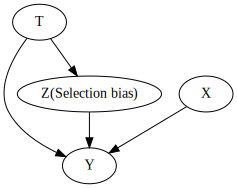

In [37]:
g = gr.Digraph()
g.edge("T","Y")
g.edge("T","Z(Selection bias)")
g.edge("Z(Selection bias)","Y")
g.edge("X","Y")
g

### Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is in cases a and b.

In [38]:
estDict = {}  
R = 2000  

for N in [100, 1000]:
    tauhats_sb1 = []
    sehats_sb1 = []
    for r in tqdm(range(R)):  
        Yexp,T,Xsb,X = fn_generate_data_sb(tau,N,p,p0,corr)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xsb,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)  
        # controlling for the variable in between the path from cause to effect
        res = mod.fit()
        tauhat_sb1 = res.params[0]
        se_tauhat_sb1 = res.HC1_se[0]
        tauhats_sb1 = tauhats_sb1 + [tauhat_sb1]
        sehats_sb1 = sehats_sb1 + [se_tauhat_sb1]
    estDict[N] = {
        'tauhat_sb1':np.array(tauhats_sb1).reshape([len(tauhats_sb1),1]),
        'sehat_sb1':np.array(sehats_sb1).reshape([len(sehats_sb1),1])
    }

100%|██████████| 2000/2000 [00:19<00:00, 101.70it/s]


In [39]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat_sb1'],
                                         results['sehat_sb1'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=-0.01594434547490772, RMSE=0.5187967191792744, size=0.0605
N=1000: bias=-0.0013479716344541033, RMSE=0.16059273192884926, size=0.0485


### Give an example of a real-life situation that might be consistent with the DGP.

For example, in the field experiment of measuring the effect of education on wage, suppose you are able to randomize education, and you don't control for the mediator(whether or not the person had a white collar job).

## b. You do not control for the variable in between the path from cause to effect

### Illustrate your DGP with a DAG

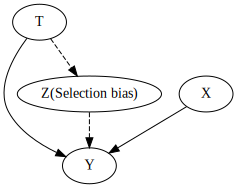

In [40]:
g = gr.Digraph()
g.edge("T","Y")
g.edge("T","Z(Selection bias)",style="dashed")
g.edge("Z(Selection bias)","Y",style="dashed")
g.edge("X","Y")
g

### Show, using a Monte Carlo experiment with sample sizes N=100 and N=1000, what the bias, RMSE and size of your treatment effect estimate is in cases a and b.

In [41]:
estDict = {}  
R = 2000  

for N in [100, 1000]:
    tauhats_sb2 = []
    sehats_sb2 = []
    for r in tqdm(range(R)):  
        Yexp,T,Xsb,X = fn_generate_data_sb(tau,N,p,p0,corr)
        Xobs = X[:,:p0]
        covars = np.concatenate([T,Xobs],axis = 1)
        mod = sm.OLS(Yexp,covars)  
        # do not control for the variable in between the path from cause to effect
        res = mod.fit()
        tauhat_sb2 = res.params[0]
        se_tauhat_sb2 = res.HC1_se[0]
        tauhats_sb2 = tauhats_sb2 + [tauhat_sb2]
        sehats_sb2 = sehats_sb2 + [se_tauhat_sb2]
    estDict[N] = {
        'tauhat_sb2':np.array(tauhats_sb2).reshape([len(tauhats_sb2),1]),
        'sehat_sb2':np.array(sehats_sb2).reshape([len(sehats_sb2),1])
    }

100%|██████████| 2000/2000 [00:19<00:00, 102.99it/s]


In [42]:
tau0 = tau*np.ones([R,1])
for N, results in estDict.items():
    (bias,rmse,size) = fn_bias_rmse_size(tau0,results['tauhat_sb2'],
                                         results['sehat_sb2'])
    print(f'N={N}: bias={bias}, RMSE={rmse}, size={size}')

N=100: bias=0.0020644438793879106, RMSE=0.14219696410720326, size=0.0515
N=1000: bias=0.001756745298115192, RMSE=0.04535621006211882, size=0.0535


### Give an example of a real-life situation that might be consistent with the DGP.

For example, in the field experiment of measuring the effect of education on wage, suppose you are able to randomize education. But, just to be sure, you decide to control whether or not the person had a white collar job. Once again, this conditioning biasses the causal effect estimation. This time, not because it opens a front door path with a collider, but because it closes one of the channels through which the treatment operates. In our example, getting a white collar job is one way that more education leads to higher pay. By controlling it, we close this channel and leave open only the direct effect of education on wage.